# AMS 526 Homework 3 
**submitted by Jiaxi Zhao on 12th Oct, 2020**

In this report, we first implement the Householder, Gram-Schmidt, and modified Gram-Schmidt QR factorization. Then, we test their accuracy and efficiency in the setting of polynomial fitting under different problem sizes. Specifically, by evaluating the target polynomial in several data points, we can rewrite the problems into a linear system. Then we factorize the coefficient matrix and sovle this linear system using back substitution.

In [29]:
import numpy as np
from matplotlib import pyplot as plt 
from time import time
from scipy.linalg import lu as lu
import scipy.linalg as alg
from scipy.linalg import solve_triangular as st
from scipy.linalg import solve as ss

## Overview of the procedure to solve linear systems using Householder QR factorization

In [116]:
n   = 5
A   = np.random.rand(n, n) * n

### Implementation of the Householder QR factorization
The Householder QR factorization is obtained by iteratively applying a orthogonal Householder reflector to original matrix to cancel its column out. In the $k$-th step, the $k$-th orthogonal factor $Q_k$ can be formulated as $Q_i = \begin{pmatrix}
        I_{k - 1} & 0    \\
        0 & F
    \end{pmatrix}$ that satisfies:
\begin{equation}
    \begin{pmatrix}
        I_{k - 1} & 0    \\
        0 & F
    \end{pmatrix}\begin{pmatrix}
        \begin{pmatrix}
        \times & \times    \\
        0 & \times
    \end{pmatrix} & \begin{pmatrix}
        \times & \times    \\
        \times & \times
    \end{pmatrix}    \\
        0 & \begin{pmatrix}
        a_{kk} & \times    \\
        \mathbf{a} & \times
    \end{pmatrix}
    \end{pmatrix} 
    = \begin{pmatrix}
        \begin{pmatrix}
        \times & \times    \\
        0 & \times
    \end{pmatrix} & \begin{pmatrix}
        \times & \times    \\
        \times & \times
    \end{pmatrix}    \\
        0 & \begin{pmatrix}
        r_{k1} & \times    \\
        0 & \times
    \end{pmatrix}
    \end{pmatrix},
\end{equation}
where $I_k \in \mathbb{R}^{(k-1) \times (k-1)}, F \in \mathbb{R}^{(n - k + 1) \times (n - k + 1)}$. And the matrix $F$ is given directly by the formula $F = I_{n - k + 1} - \frac{2vv^T}{v^Tv}$ with $v = \mathbf{x} + sgn(\mathbf{x}_1)\left\| \mathbf{x} \right\|e_k$. Here, $\mathbf{x}$ is the $\mathbb{R}^{(n - k + 1) \times 1}$-vector  $\mathbf{x} = \begin{pmatrix}a_{kk} \\ \mathbf{a} \end{pmatrix}$ and $sgn(\cdot)$ is the sign function chosen to make the inner product $v^Tv$ away from $0$.

While for Gram-Schmidt QR factorization, the procedure is simpler. We simply view the column of $A$ as a set of vectors and orthogonalize them one by one. Notice that the modified Gram-Schmidt algorithm differs from the original one only in the order to perform column normalization and element cancellation. These three algorithms are implemented as below.

In [105]:
tol = 1E-12

def sgn(x):
    # Modified sign function
    if x == 0:
        return 1
    else:
        return np.sign(x)

def QR_HR(A):
    # QR factorization using Householder reflector, the R is stored in original A while the set of orthognal 
    # is stored in v matrix
    #B = A.copy()
    [m, n]     = A.shape
    v          = np.zeros([m, n])
    for k in range(n):
        v_k    = A[k : m, k].reshape(m - k, 1).copy() 
        v_k[0] = sgn(v_k[0]) * alg.norm(v_k, 2) + v_k[0]
        if alg.norm(v_k, 2) < tol:
            # abnormal case
            v_k = 0
        else:
            v_k    = v_k / alg.norm(v_k, 2)
        A[k : m, k : n] = A[k : m, k : n] - 2 * v_k.dot(v_k.T.dot(A[k : m, k : n]))
        v[k : m, k]     = v_k.reshape(m - k)
    
    #print(A)
    #print(alg.det(B) - alg.det(A))
    #print(alg.det(B) + alg.det(A))
    #print(v)
    return v
  
def QR_MGS(A):
    # QR factorization using modified Gram-Schimdt orthognalization
    #B = A.copy()
    [m, n]      = A.shape
    v           = np.zeros([m, n])
    for k in range(n):
        v[:, k] = A[:, k].copy()
        
    for k in range(n):
        A[k, k]     = alg.norm(v[:, k])
        if A[k, k] < tol:
            # abnormal case
            v[:, k] = 0
        else:
            v[:, k] = v[:, k] / A[k, k]
        for j in range(k + 1, n):
            A[k, j] = v[:, k].dot(v[:, j])
            A[j, k] = 0
            v[:, j] = v[:, j] - A[k, j] * v[:, k]
    
    #print(A)
    #print(alg.det(B) - alg.det(A))
    #print(alg.det(B) + alg.det(A))
    #print(B - v.dot(A))
    #print(v.dot(v.T))
    return v

def QR_GS(A):
    # QR factorization using modified Gram-Schimdt orthognalization
    #B = A.copy()
    [m, n]      = A.shape
    v           = np.zeros([m, n])
    for k in range(n):
        v[:, k] = A[:, k].copy()
        
    for k in range(n):       
        for j in range(k):
            A[j, k] = v[:, k].dot(v[:, j])
            A[k, j] = 0
            v[:, k] = v[:, k] - A[j, k] * v[:, j]
        A[k, k]     = alg.norm(v[:, k])
        if A[k, k] < tol:
            # abnormal case
            v[:, k] = 0
        else:
            v[:, k] = v[:, k] / A[k, k]
    
    #print(A)
    #print(alg.det(B) - alg.det(A))
    #print(alg.det(B) + alg.det(A))
    #print(B - v.dot(A))
    #print(v.dot(v.T))
    return v

### Solving the linear system $Ax = b$ using QR factorization
To solve the linear system $Ax = b$ using QR factorization, we proceed in following two steps. Firstly, we calculate the $\hat{Q}^Tb$ using the array of orthogonal vector $v_k$ calculated in QR factorization. Notice that this step can be further simplified in Householder algorithm, since the reflected vectors have descending number of non-zero components. Then, we solve the remained upper triangular linear system using back substitution.

In [106]:
def My_solve(v, R, b, opt):
    # linear solver that uses implicit calculation and back substitution to solve a QR-form linear system
    [m, n]       = v.shape
    x            = np.zeros([n, 1])
    
    if opt == 'HR':
        # Implicit calculation step of Householder reflector
        for k in range(n):
            v_k      = v[k : m, k].reshape(m - k, 1).copy()
            b[k : m] = b[k : m] - 2 * v_k.dot(v_k.T.dot(b[k : m]))
    else:
        # MGS & GS step
        b = v.T.dot(b)
    
    # Back substitution step
    for k in range(1, n + 1):
        x[n - k] = b[n - k] / R[n - k, n - k]
        b        = b - x[n - k] * R[0:b.size, n - k].reshape(b.size)
    
    return x

In [ ]:
Here is a

In [107]:
n   = 5
A1  = np.random.rand(n, n) * n
A2  = A1.copy()
A   = A1.copy()
b1  = np.random.rand(n)
b2  = b1.copy()
b   = b1.copy()
v1  = QR_HR(A1)
v2  = QR_GS(A2)
x1  = My_solve(v1, A1, b1, 'HR')
x2  = My_solve(v2, A2, b2, 'GS')
print(b - A.dot(x1).reshape(n))
print(b - A.dot(x2).reshape(n))

[ 0.00000000e+00 -2.22044605e-16  5.55111512e-17 -1.11022302e-16
  0.00000000e+00]
[ 1.11022302e-16 -4.44089210e-16  9.43689571e-16 -9.99200722e-16
 -5.55111512e-16]


## Numerical experiment on polynomial fitting
In this section, we test our algorithm on the problem of polynomial fitting. Specifically, we artificially generate a polynomial $f \in \mathbb{R}[x]$ and evaluate it at several points $x_1, x_2,\cdots, x_m$, i.e. $y_i = f(x_i)$. Based on this set of data, we can denote the coefficients of polynomial $f$ as $f(x) = \sum_{i = 0}^{n - 1} \theta_i x^i$. Here we choose the number of samples to be twice as many as the number of parameters, i.e. $m = 2n$. And these sample points are equi-distributed on the interval $[0, 1]$, i.e. $x_i = \frac{i - 1}{m - 1}$.

In [108]:
k        = 20
error    = np.zeros([k, 3])
t_c      = np.zeros([k, 3])
num      = 1000

for n in range(3, 3 + k):
    m    = 2 * n
    
    # generate data point
    data = np.zeros([m, 2])
    for i in range(m):
        data[i, 0] = (i - 1) / (m - 1)
    for i in range(n):
        data[:, 1] = data[:, 1] + np.power(data[:, 0], i)
    A    = np.zeros([m, n])
    for i in range(m):
        for j in range(n):
            A[i, j] = np.power(data[i, 0], j)

    start    = time()
    for i in range(num):
        
        A1_  = A.copy()
        d1   = data[:, 1].copy()
        v1   = QR_HR(A1_)
        #v1   = np.random.rand(m, n)
        x1   = My_solve(v1, A1_, d1, 'HR')
        error[n - 3, 0] = alg.norm(x1 - np.ones(n), 2) + error[n - 3, 0]
    t_c[n - 3, 0] = (time() - start) / num
    
    start    = time()
    for i in range(num):
        
        A2_  = A.copy()
        d2   = data[:, 1].copy()
        v2   = QR_MGS(A2_)
        #v2   = np.random.rand(m, n)
        x2   = My_solve(v2, A2_, d2, 'MGS')    
        error[n - 3, 1] = alg.norm(x2 - np.ones(n), 2) + error[n - 3, 1] 
    t_c[n - 3, 1] = (time() - start) / num
    
    start    = time()
    for i in range(num):
        
        A3_  = A.copy()
        d3   = data[:, 1].copy()
        v3   = QR_GS(A3_)
        #v2   = np.random.rand(m, n)
        x3   = My_solve(v3, A3_, d3, 'GS')    
        error[n - 3, 2] = alg.norm(x3 - np.ones(n), 2) + error[n - 3, 2] 
    t_c[n - 3, 2] = (time() - start) / num
        
error = error / num

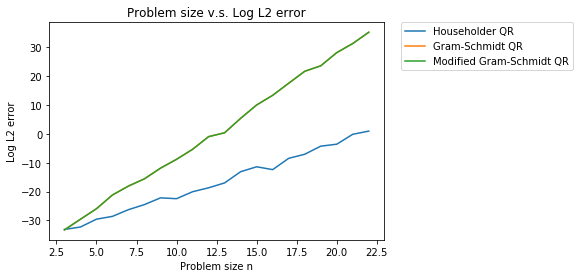

In [113]:
plt.title("Problem size v.s. Log L2 error") 
plt.xlabel("Problem size n") 
plt.ylabel("Log L2 error") 
plt.plot(range(3, k + 3), np.log(error[:, 0]), label = "Householder QR")
plt.plot(range(3, k + 3), np.log(error[:, 2]), label = "Gram-Schmidt QR")
plt.plot(range(3, k + 3), np.log(error[:, 1]), label = "Modified Gram-Schmidt QR")
plt.legend(bbox_to_anchor = (1.05, 1), loc = 'upper left', borderaxespad = 0.)
plt.show()

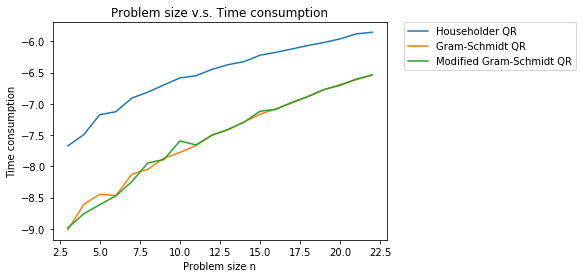

In [115]:
plt.title("Problem size v.s. Time consumption") 
plt.xlabel("Problem size n") 
plt.ylabel("Time consumption") 
plt.plot(range(3, k + 3), np.log(t_c[:, 0]), label = "Householder QR")
plt.plot(range(3, k + 3), np.log(t_c[:, 2]), label = "Gram-Schmidt QR")
plt.plot(range(3, k + 3), np.log(t_c[:, 1]), label = "Modified Gram-Schmidt QR")
plt.legend(bbox_to_anchor = (1.05, 1), loc = 'upper left', borderaxespad = 0.)
plt.show()

\begin{remark}
    From the above summary on numerical experiment, we conclude that two algorithms(Householder and modified Gram-Schmidt) have significantly different performance on the large scale problem (not large in general, only $n = 20$). The Householder QR factorization provides more stable solution, which still returns reasonable results on large scale problem. While the modified Gram-Schimdt QR factorization is less stable in the sense that although it takes less time to run, its performance is notoriously bad in relatively large case. Its answer to the polynomial fitting problem cannot be used.
     \par Apart from this, we also conduct numerical experiments on Gram-Schmidt and modified Gram-Schmidt algorithm, which only differ in their order to normalize the vector and update. Classically, the modified Gram-Schmidt algorithm is understood to be more stable than ordinary Gram-Schmidt. However, this phenomenon is not observed in our experiment, i.e. the error curves of these two algorithms mostly overlap.
\end{remark}

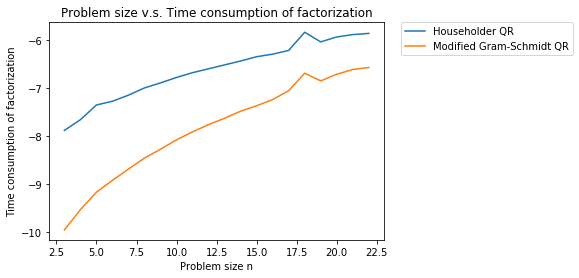

In [95]:
plt.title("Problem size v.s. Time consumption of factorization") 
plt.xlabel("Problem size n") 
plt.ylabel("Time consumption of factorization") 
plt.plot(range(3, k + 3), np.log(t_c[:, 0]), label = "Householder QR")
plt.plot(range(3, k + 3), np.log(t_c[:, 1]), label = "Modified Gram-Schmidt QR")
plt.legend(bbox_to_anchor = (1.05, 1), loc = 'upper left', borderaxespad = 0.)
plt.show()

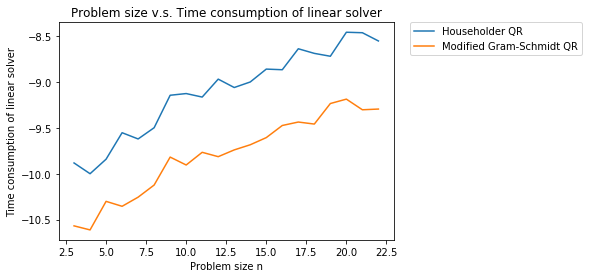

In [97]:
plt.title("Problem size v.s. Time consumption of linear solver") 
plt.xlabel("Problem size n") 
plt.ylabel("Time consumption of linear solver") 
plt.plot(range(3, k + 3), np.log(t_c[:, 0]), label = "Householder QR")
plt.plot(range(3, k + 3), np.log(t_c[:, 1]), label = "Modified Gram-Schmidt QR")
plt.legend(bbox_to_anchor = (1.05, 1), loc = 'upper left', borderaxespad = 0.)
plt.show()

\begin{remark}
    Apart from the above summary on numerical experiment, we also separately calculate the timing of different part of these algorithms, namely, the factorization part and linear solver part. It is simple to observe that the factorization part consumes much more time than the linear solver part, which is consistent with the fact that the factorization part has complexity $O(n^3)$ while linear solver part only $O(n^2)$.
\end{remark}